# Software analytics: Increase code review speed — impact on global colaboration in large projects

## Imports

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.mstats import pearsonr, spearmanr
from scipy.stats import kendalltau
import scipy.stats as stats
from statsmodels.nonparametric.smoothers_lowess import lowess

## Load data

https://zenodo.org/records/3922907

In [12]:
def load_data():
    data = pd.read_csv('./data/new_pullreq.csv', header=0)
    return data
data = load_data()
data

,id,project_id,ownername,reponame,merged_or_not,lifetime_minutes,mergetime_minutes,num_commits,src_churn,test_churn,...,other_comment,num_comments_con,num_code_comments,num_code_comments_con,integrator_availability,friday_effect,contrib_rate_author,reopen_or_not,first_close_minutes,reopen_num
0,1,13708387,stylelint,stylelint,1,237,237.0,1,0,0,...,0,0,0,0,30.0,1,0.007948,0,237,0
1,2,100297899,Joaogarciadelima,checklistos,0,1410,NaN,1,0,0,...,0,2,0,0,597.0,0,0.830769,0,1410,0
2,3,93139005,binary-com,SmartCharts,1,4,4.0,1,0,0,...,0,0,0,0,2.0,0,0.314368,0,4,0
3,4,15059440,letsencrypt,boulder,1,52,52.0,1,9,104,...,0,0,0,0,1.0,0,0.117332,0,52,0
4,5,29684214,PyCQA,astroid,1,2414,2414.0,1,33,27,...,0,0,0,0,2.0,0,0.010753,0,2414,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3347932,3347933,30544060,Kronos-Integration,kronos-service-consul,1,9,9.0,1,0,0,...,0,0,0,0,2537.0,0,0.696970,0,9,0
3347933,3347934,1142,saltstack,salt,0,1165,NaN,1,10,0,...,0,1,0,0,42.0,0,0.056849,0,1165,0
3347934,3347935,31499094,mjmlio,mjml,1,8834,8834.0,2,6,0,...,0,8,0,0,597.0,0,0.002041,0,8834,0
3347935,3347936,55317,zotonic,zotonic,0,703,NaN,7,15,0,...,0,0,0,0,10.0,0,0.000732,0,703,0


In [13]:
for key in data.keys():
    print(key)

id
project_id
ownername
reponame
merged_or_not
lifetime_minutes
mergetime_minutes
num_commits
src_churn
test_churn
files_added
files_deleted
files_modified
files_changed
src_files
doc_files
other_files
num_commit_comments
num_issue_comments
num_comments
num_participants
sloc
team_size
perc_external_contribs
commits_on_files_touched
test_lines_per_kloc
test_cases_per_kloc
asserts_per_kloc
watchers
prev_pullreqs
requester_succ_rate
followers
churn_addition
churn_deletion
pr_comment_num
comment_num
perc_neg_emotion
perc_pos_emotion
perc_neu_emotion
part_num_issue
part_num_commit
part_num_pr
part_num_code
comment_conflict
hash_tag
at_tag
test_inclusion
description_length
bug_fix
ci_exists
ci_latency
ci_build_num
ci_test_passed
ci_failed_perc
ci_first_build_status
ci_last_build_status
language
fork_num
project_age
open_issue_num
pr_succ_rate
open_pr_num
first_response_time
pushed_delta
acc_commit_num
first_pr
account_creation_days
core_member
contrib_gender
contrib_country
contrib_affiliati

## Overview  & filtering of data of large projects

Number of projects: 11230


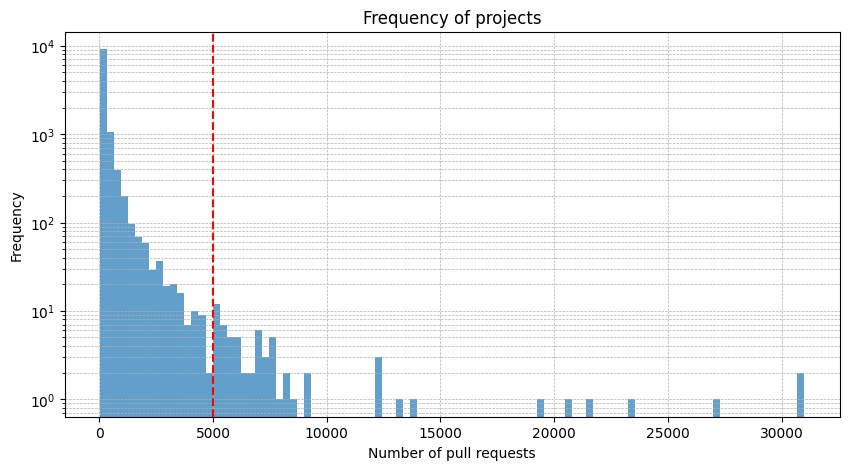

Number of project with more than 5000 pull requests: 64


In [14]:
num_projects = data['project_id'].unique()
print('Number of projects: {}'.format(len(num_projects)))

projects = data['project_id'].value_counts()
project_ids = projects.index
num_pull_requests = projects.values

plt.figure(figsize=(10, 5))
plt.hist(num_pull_requests, bins=100, alpha=0.7, log=True)
plt.axvline(x=5000, color='r', linestyle='--')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Frequency of projects')
plt.xlabel('Number of pull requests')
plt.ylabel('Frequency')
plt.show()

print('Number of project with more than 5000 pull requests: {}'.format(len(projects[num_pull_requests > 5000])))
filtered_project_ids_pr = projects[num_pull_requests > 5000].index

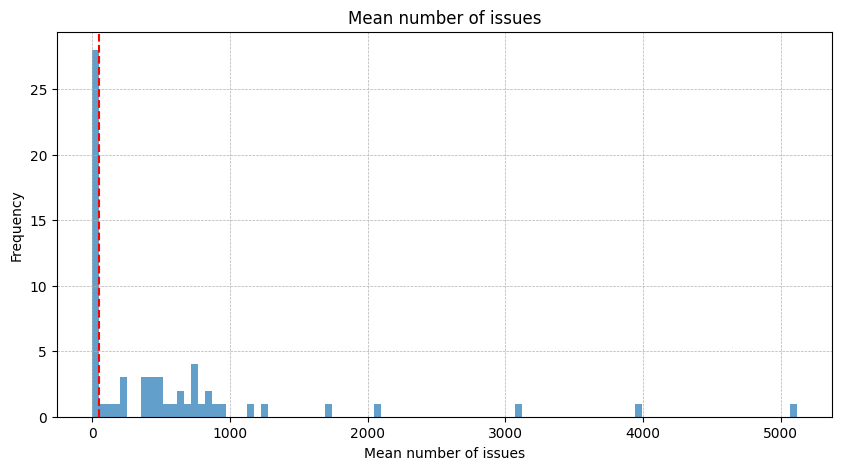

Number of project with more than 50 issues: 36


In [15]:
opened_issues = data[data['project_id'].isin(filtered_project_ids_pr)].groupby('project_id')['open_issue_num'].mean()

plt.figure(figsize=(10, 5))
plt.hist(opened_issues, bins=100, alpha=0.7)
plt.axvline(x=50, color='r', linestyle='--')
plt.xlabel('Mean number of issues')
plt.ylabel('Frequency')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Mean number of issues')
plt.show()

filtered_project_ids_issue = opened_issues[opened_issues > 50].index
print('Number of project with more than 50 issues: {}'.format(len(filtered_project_ids_issue)))

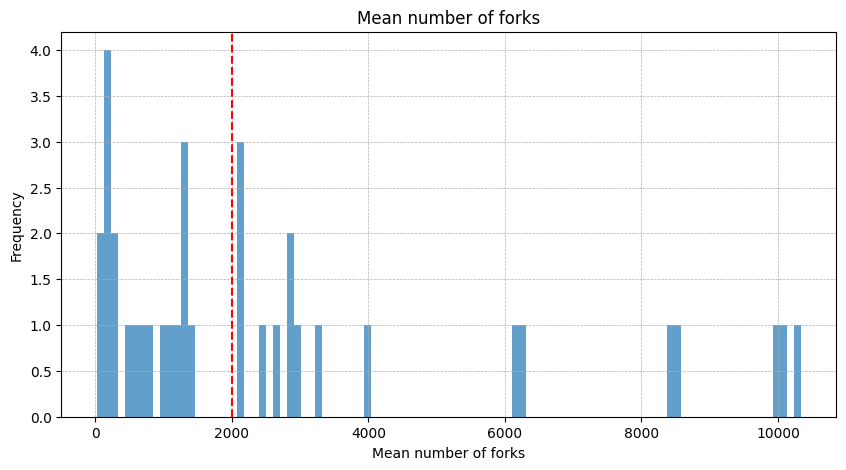

Number of project with more than 2000 forks: 17


In [16]:
forks = data[data['project_id'].isin(filtered_project_ids_issue)].groupby('project_id')['fork_num'].mean()
plt.figure(figsize=(10, 5))
plt.hist(forks, bins=100, alpha=0.7)
plt.axvline(x=2000, color='r', linestyle='--')
plt.xlabel('Mean number of forks')
plt.ylabel('Frequency')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Mean number of forks')
plt.show()

filtered_project_ids_forks = forks[forks > 2000].index
print('Number of project with more than 2000 forks: {}'.format(len(filtered_project_ids_forks)))

## Analysis of filtered data

In [17]:
print(data[data['project_id'].isin(filtered_project_ids_forks)]['reponame'].unique())
filtered_data = data[data['project_id'].isin(filtered_project_ids_forks)]
print('Number of pull requests: {}'.format(len(filtered_data)))
filtered_data

['scikit-learn' 'salt' 'metasploit-framework' 'kubernetes' 'react' 'node'
 'ansible' 'playframework' 'odoo' 'three.js' 'rails' 'matplotlib'
 'ember.js' 'pandas' 'mastodon' 'gatsby' 'spree']
Number of pull requests: 210520


,id,project_id,ownername,reponame,merged_or_not,lifetime_minutes,mergetime_minutes,num_commits,src_churn,test_churn,...,other_comment,num_comments_con,num_code_comments,num_code_comments_con,integrator_availability,friday_effect,contrib_rate_author,reopen_or_not,first_close_minutes,reopen_num
30,31,5219,scikit-learn,scikit-learn,0,122459,NaN,3,201,504,...,1,8,199,2,60.0,0,0.000373,0,122459,0
34,35,1142,saltstack,salt,1,4534,4534.0,1,22,0,...,0,1,0,0,49.0,1,0.000622,0,4534,0
40,41,1142,saltstack,salt,1,983,983.0,1,193,0,...,0,0,0,0,3.0,0,0.000013,0,983,0
44,45,853,rapid7,metasploit-framework,1,131,131.0,1,2,0,...,0,0,0,0,159.0,0,0.000023,0,131,0
51,52,22091370,kubernetes,kubernetes,1,627,627.0,1,8,19,...,1,3,0,0,0.0,0,0.000459,0,627,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3347814,3347815,48212908,pandas-dev,pandas,1,63531,63531.0,215,9804,13464,...,1,13,17,3,7.0,0,0.000274,1,10204,1
3347881,3347882,20078281,nodejs,node,1,11373,11373.0,4,16,0,...,1,9,0,0,197.0,0,0.012812,0,11373,0
3347882,3347883,853,rapid7,metasploit-framework,1,1248,1248.0,4,66,0,...,0,1,2,0,113.0,0,0.001935,0,1248,0
3347907,3347908,3905191,facebook,react,1,484,484.0,1,0,0,...,1,0,0,0,12.0,0,0.097158,0,484,0


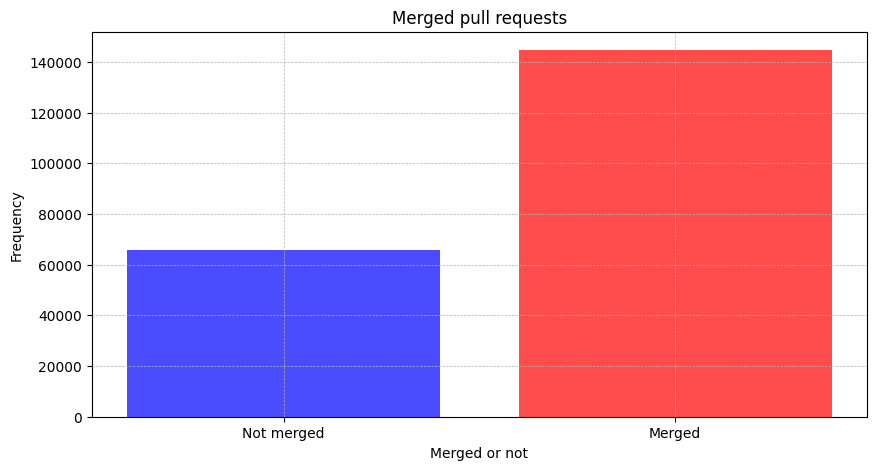

In [18]:
num_merged = filtered_data['merged_or_not'].value_counts().sort_index()
plt.figure(figsize=(10, 5))
plt.bar(num_merged.index, num_merged.values, alpha=0.7, color=['blue', 'red'])
plt.xticks(num_merged.index, ['Not merged', 'Merged'])
plt.xlabel('Merged or not')
plt.ylabel('Frequency')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Merged pull requests')
plt.show()

## Pearson
The Pearson correlation coefficient measures the linear relationship between two datasets. The calculation of the p-value relies on the assumption that each dataset is normally distributed. Like other correlation coefficients, this one varies between -1 and +1 with 0 implying no correlation. Correlations of -1 or +1 imply an exact linear relationship.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mstats.pearsonr.html#scipy.stats.mstats.pearsonr

## Spearman
The Spearman correlation is a nonparametric measure of the linear relationship between two datasets. Unlike the Pearson correlation, the Spearman correlation does not assume that both datasets are normally distributed. Like other correlation coefficients, this one varies between -1 and +1 with 0 implying no correlation. Correlations of -1 or +1 imply a monotonic relationship. Positive correlations imply that as x increases, so does y. Negative correlations imply that as x increases, y decreases.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mstats.spearmanr.html#scipy.stats.mstats.spearmanr

## Kendall tau
Kendall’s tau is a measure of the correspondence between two rankings. Values close to 1 indicate strong agreement, and values close to -1 indicate strong disagreement. This implements two variants of Kendall’s tau: tau-b (the default) and tau-c (also known as Stuart’s tau-c). These differ only in how they are normalized to lie within the range -1 to 1; the hypothesis tests (their p-values) are identical. Kendall’s original tau-a is not implemented separately because both tau-b and tau-c reduce to tau-a in the absence of ties.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kendalltau.html

Mean merge time: 20004.992084013164
Median merge time: 1108.0
Standard deviation of merge time: 85618.19512469816
Minimum merge time: 0.0
Maximum merge time: 2916770.0


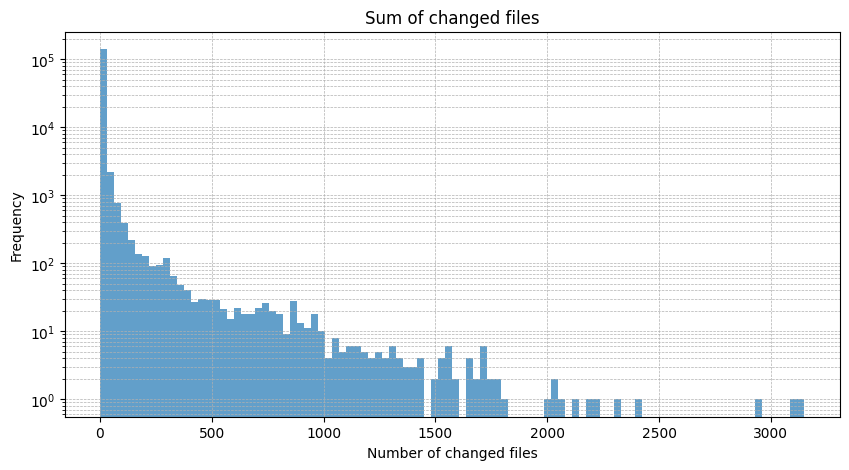

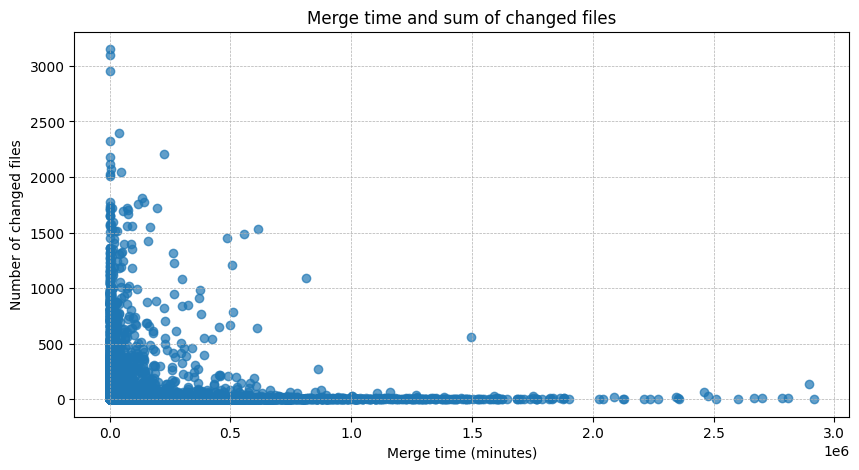

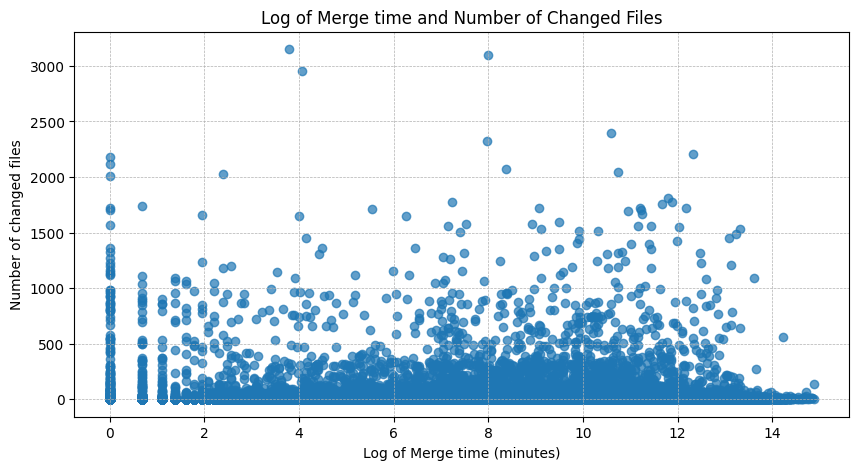

In [45]:
merged_data = filtered_data[filtered_data['merged_or_not'] == 1]

print('Mean merge time: {}'.format(merged_data['mergetime_minutes'].mean()))
print('Median merge time: {}'.format(merged_data['mergetime_minutes'].median()))
print('Standard deviation of merge time: {}'.format(merged_data['mergetime_minutes'].std()))
print('Minimum merge time: {}'.format(merged_data['mergetime_minutes'].min()))
print('Maximum merge time: {}'.format(merged_data['mergetime_minutes'].max()))

plt.figure(figsize=(10, 5))
plt.hist(merged_data['files_changed'], bins=100, alpha=0.7, log=True)
plt.xlabel('Number of changed files')
plt.ylabel('Frequency')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Sum of changed files')
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(merged_data['mergetime_minutes'], merged_data['files_changed'], alpha=0.7)
plt.xlabel('Merge time (minutes)')
plt.ylabel('Number of changed files')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Merge time and sum of changed files')
plt.show()

log_data = np.log1p(merged_data['mergetime_minutes'])
plt.figure(figsize=(10, 5))
plt.scatter(log_data, merged_data['files_changed'], alpha=0.7)
plt.xlabel('Log of Merge time (minutes)')
plt.ylabel('Number of changed files')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Log of Merge time and Number of Changed Files')
plt.show()

lowess_data = lowess(merged_data['files_changed'], log_data, frac=0.3)
plt.figure(figsize=(10, 5))
plt.scatter(log_data, merged_data['files_changed'], alpha=0.7)
plt.plot(lowess_data[:, 0], lowess_data[:, 1], color='red')
plt.xlabel('Merge time (minutes)')
plt.ylabel('Number of changed files')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Lowess of Merge time and Number of Changed Files')
plt.show()

correlation_size = pearsonr(merged_data['mergetime_minutes'], merged_data['files_changed'])
correlation_size_spear = spearmanr(merged_data['mergetime_minutes'], merged_data['files_changed'])
magnitude_size = kendalltau(merged_data['mergetime_minutes'], merged_data['files_changed'])
print('Correlation between merge time and number of changed files: {}'.format(correlation_size))
print('Spearman correlation between merge time and number of changed files: {}'.format(correlation_size_spear))
print('Kendall tau between merge time and number of changed files: {}'.format(magnitude_size))

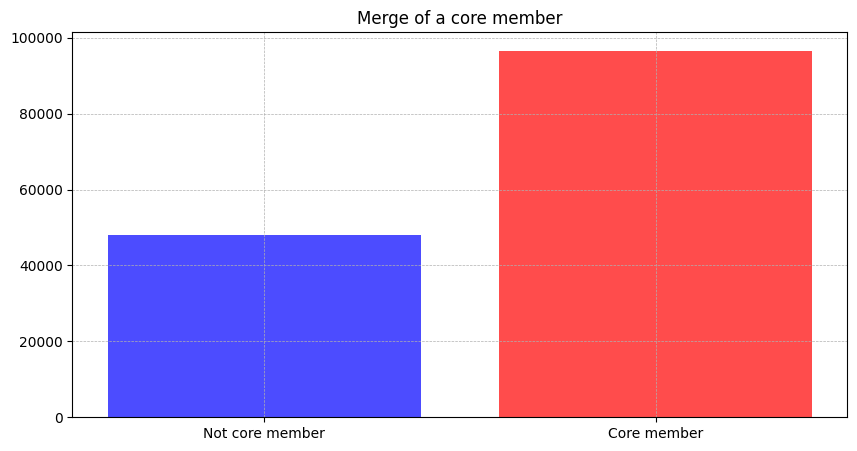

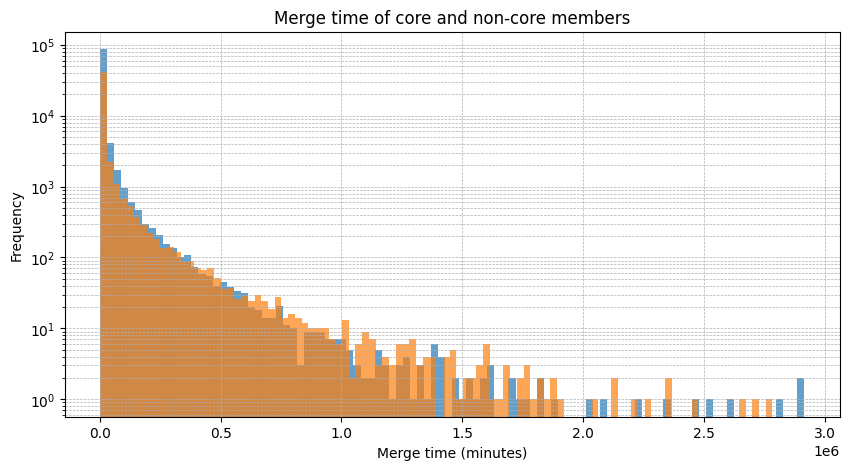

Mean merge time of core member: 16107.61065518633
Mean merge time of non-core member: 27848.375820056233
Median merge time of core member: 1096.0
Median merge time of non-core member: 1138.0
Standard deviation of merge time of core member: 70076.31302096572
Standard deviation of merge time of non-core member: 110037.94185100144
Minimum merge time of core member: 0.0
Minimum merge time of non-core member: 0.0
Maximum merge time of core member: 2916770.0
Maximum merge time of non-core member: 2784300.0


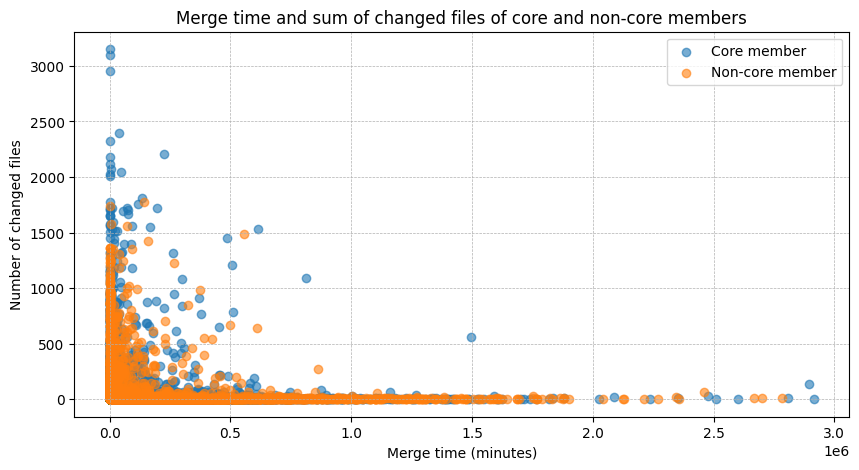

Correlation between merge time and number of changed files of core member: PearsonRResult(statistic=0.037055972197286485, pvalue=1.0134432090049162e-30)
Spearman correlation between merge time and number of changed files of core member: SignificanceResult(statistic=0.2794121712837335, pvalue=0.0)
Kendall tau between merge time and number of changed files of core member: SignificanceResult(statistic=0.2049559839743082, pvalue=0.0)
Correlation between merge time and number of changed files of non-core member: PearsonRResult(statistic=0.019233254129202484, pvalue=2.500735156020363e-05)
Spearman correlation between merge time and number of changed files of non-core member: SignificanceResult(statistic=0.262345521078397, pvalue=0.0)
Kendall tau between merge time and number of changed files of non-core member: SignificanceResult(statistic=0.19929752783170832, pvalue=0.0)


In [34]:
core = merged_data['core_member'].value_counts().sort_index()
plt.figure(figsize=(10, 5))
plt.bar(core.index, core.values, alpha=0.7, color=['blue', 'red'])
plt.xticks(core.index, ['Not core member', 'Core member'])
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Merge of a core member')
plt.show()

core_data = merged_data[merged_data['core_member'] == 1]
non_core_data = merged_data[merged_data['core_member'] == 0]
plt.figure(figsize=(10, 5))
plt.hist(core_data['mergetime_minutes'], bins=100, alpha=0.7, label='Core member', log=True)
plt.hist(non_core_data['mergetime_minutes'], bins=100, alpha=0.7, label='Non-core member', log=True)
plt.xlabel('Merge time (minutes)')
plt.ylabel('Frequency')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Merge time of core and non-core members')
plt.show()

print('Mean merge time of core member: {}'.format(core_data['mergetime_minutes'].mean()))
print('Mean merge time of non-core member: {}'.format(non_core_data['mergetime_minutes'].mean()))
print('Median merge time of core member: {}'.format(core_data['mergetime_minutes'].median()))
print('Median merge time of non-core member: {}'.format(non_core_data['mergetime_minutes'].median()))
print('Standard deviation of merge time of core member: {}'.format(core_data['mergetime_minutes'].std()))
print('Standard deviation of merge time of non-core member: {}'.format(non_core_data['mergetime_minutes'].std()))
print('Minimum merge time of core member: {}'.format(core_data['mergetime_minutes'].min()))
print('Minimum merge time of non-core member: {}'.format(non_core_data['mergetime_minutes'].min()))
print('Maximum merge time of core member: {}'.format(core_data['mergetime_minutes'].max()))
print('Maximum merge time of non-core member: {}'.format(non_core_data['mergetime_minutes'].max()))

plt.figure(figsize=(10, 5))
plt.scatter(core_data['mergetime_minutes'], core_data['files_changed'], alpha=0.6, label='Core member')
plt.scatter(non_core_data['mergetime_minutes'], non_core_data['files_changed'], alpha=0.6, label='Non-core member')
plt.xlabel('Merge time (minutes)')
plt.ylabel('Number of changed files')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Merge time and sum of changed files of core and non-core members')
plt.legend()
plt.show()

correlation_core = pearsonr(core_data['mergetime_minutes'], core_data['files_changed'])
correlation_core_spear = spearmanr(core_data['mergetime_minutes'], core_data['files_changed'])
magnitude_core = kendalltau(core_data['mergetime_minutes'], core_data['files_changed'])
correlation_non_core = pearsonr(non_core_data['mergetime_minutes'], non_core_data['files_changed'])
correlation_non_core_spear = spearmanr(non_core_data['mergetime_minutes'], non_core_data['files_changed'])
magnitude_non_core = kendalltau(non_core_data['mergetime_minutes'], non_core_data['files_changed'])
print('Correlation between merge time and number of changed files of core member: {}'.format(correlation_core))
print('Spearman correlation between merge time and number of changed files of core member: {}'.format(correlation_core_spear))
print('Kendall tau between merge time and number of changed files of core member: {}'.format(magnitude_core))
print('Correlation between merge time and number of changed files of non-core member: {}'.format(correlation_non_core))
print('Spearman correlation between merge time and number of changed files of non-core member: {}'.format(correlation_non_core_spear))
print('Kendall tau between merge time and number of changed files of non-core member: {}'.format(magnitude_non_core))	

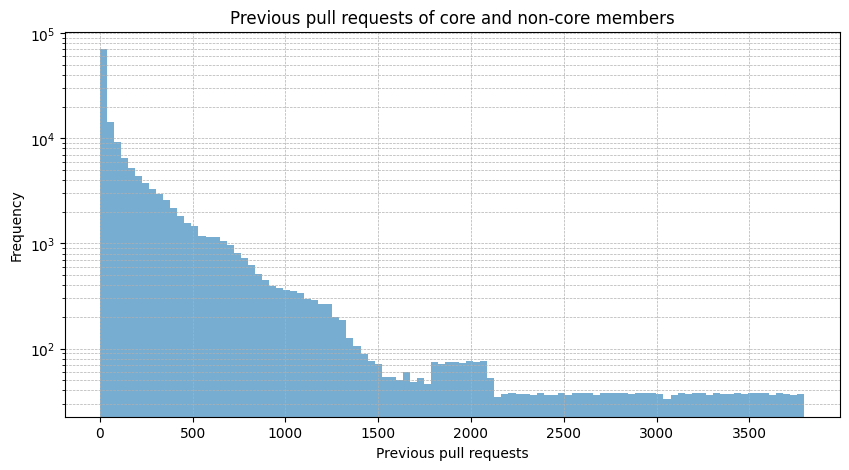

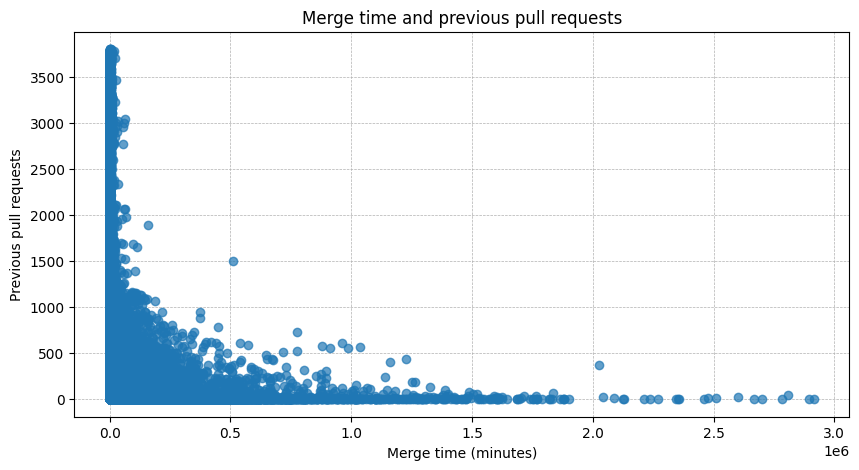

Correlation between merge time and previous pull requests: PearsonRResult(statistic=-0.0710740938692983, pvalue=2.54655735970475e-161)
Spearman correlation between merge time and previous pull requests: SignificanceResult(statistic=-0.16387433230316364, pvalue=0.0)
Kendall tau between merge time and previous pull requests: SignificanceResult(statistic=-0.11045052620504421, pvalue=0.0)


In [35]:
plt.figure(figsize=(10, 5))
plt.hist(merged_data['prev_pullreqs'], bins=100, alpha=0.6, log=True)
plt.xlabel('Previous pull requests')
plt.ylabel('Frequency')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Previous pull requests of core and non-core members')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(merged_data['mergetime_minutes'], merged_data['prev_pullreqs'], 'o', alpha=0.7)
plt.xlabel('Merge time (minutes)')
plt.ylabel('Previous pull requests')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Merge time and previous pull requests')
plt.show()

correlation_prev_pr = pearsonr(merged_data['mergetime_minutes'], merged_data['prev_pullreqs'])
correlation_prev_pr_spear = spearmanr(merged_data['mergetime_minutes'], merged_data['prev_pullreqs'])
magnitude_prev_pr = kendalltau(merged_data['mergetime_minutes'], merged_data['prev_pullreqs'])
print('Correlation between merge time and previous pull requests: {}'.format(correlation_prev_pr))
print('Spearman correlation between merge time and previous pull requests: {}'.format(correlation_prev_pr_spear))
print('Kendall tau between merge time and previous pull requests: {}'.format(magnitude_prev_pr))


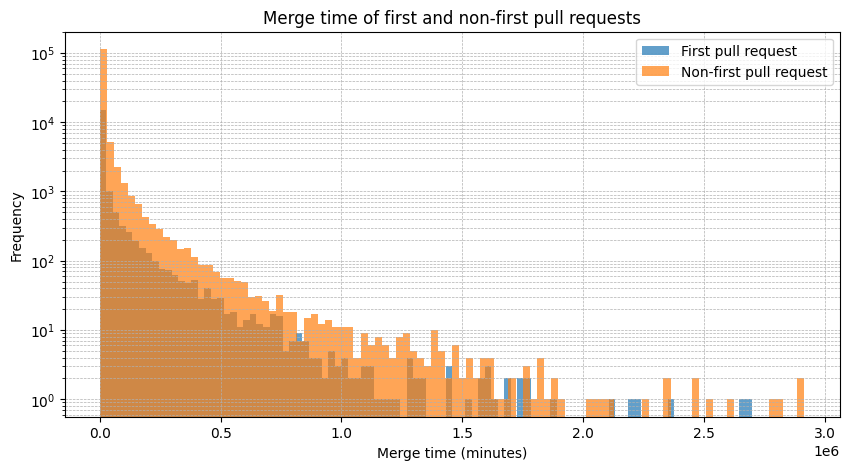

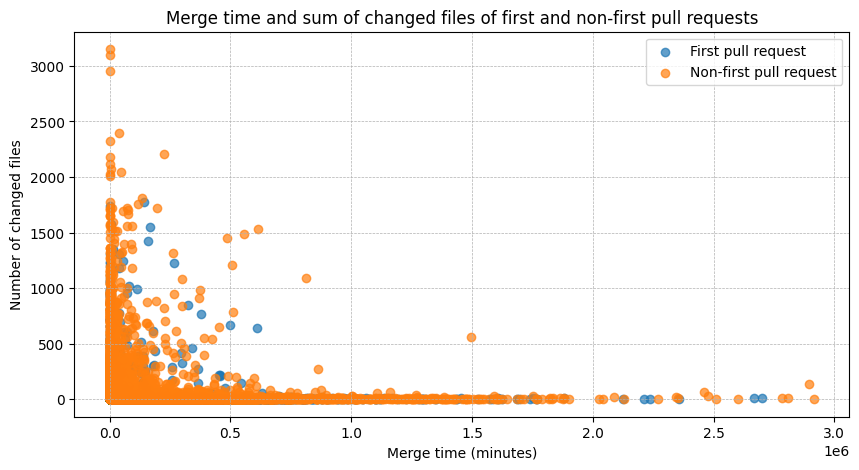

Correlation between merge time and first pull request: SignificanceResult(statistic=0.07158851148302985, pvalue=1.2190496373471357e-163)


In [36]:
first_pr = merged_data[merged_data['first_pr'] == 1]
non_first_pr = merged_data[merged_data['first_pr'] == 0]
plt.figure(figsize=(10, 5))
plt.hist(first_pr['mergetime_minutes'], bins=100, alpha=0.7, label='First pull request', log=True)
plt.hist(non_first_pr['mergetime_minutes'], bins=100, alpha=0.7, label='Non-first pull request', log=True)
plt.xlabel('Merge time (minutes)')
plt.ylabel('Frequency')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Merge time of first and non-first pull requests')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(first_pr['mergetime_minutes'], first_pr['files_changed'], alpha=0.7, label='First pull request')
plt.scatter(non_first_pr['mergetime_minutes'], non_first_pr['files_changed'], alpha=0.7, label='Non-first pull request')
plt.xlabel('Merge time (minutes)')
plt.ylabel('Number of changed files')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Merge time and sum of changed files of first and non-first pull requests')
plt.legend()
plt.show()

stats.pointbiserialr(merged_data['first_pr'], merged_data['mergetime_minutes'])
print('Correlation between merge time and first pull request: {}'.format(stats.pointbiserialr(merged_data['first_pr'], merged_data['mergetime_minutes'])))

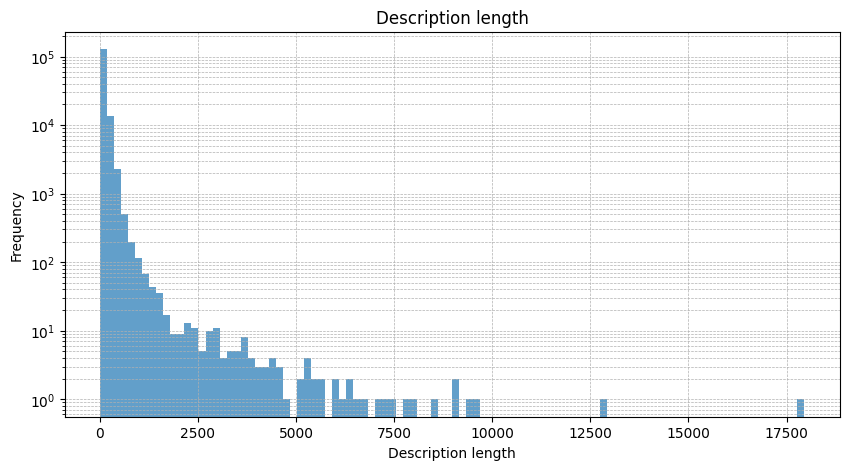

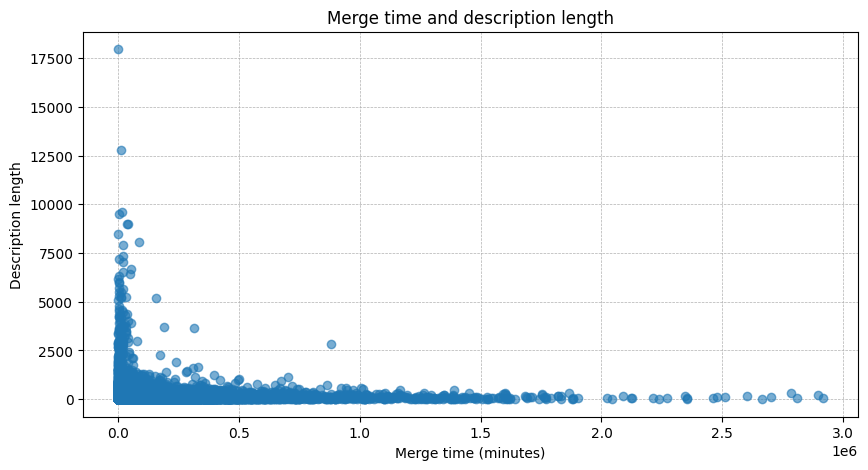

Correlation between merge time and description length: PearsonRResult(statistic=0.059787223457571044, pvalue=1.1823735609243882e-114)
Spearman correlation between merge time and description length: SignificanceResult(statistic=0.3727827448789902, pvalue=0.0)
Kendall tau between merge time and description length: SignificanceResult(statistic=0.2536948793710115, pvalue=0.0)


In [37]:
plt.figure(figsize=(10, 5))
plt.hist(merged_data['description_length'], bins=100, alpha=0.7, log=True)
plt.xlabel('Description length')
plt.ylabel('Frequency')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Description length')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(merged_data['mergetime_minutes'], merged_data['description_length'], 'o', alpha=0.6)
plt.xlabel('Merge time (minutes)')
plt.ylabel('Description length')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Merge time and description length')
plt.show()

correlation_description_len = pearsonr(merged_data['mergetime_minutes'], merged_data['description_length'])
correlation_description_len_spear = spearmanr(merged_data['mergetime_minutes'], merged_data['description_length'])
magnitudde_description_len = kendalltau(merged_data['mergetime_minutes'], merged_data['description_length'])
print('Correlation between merge time and description length: {}'.format(correlation_description_len))    
print('Spearman correlation between merge time and description length: {}'.format(correlation_description_len_spear))
print('Kendall tau between merge time and description length: {}'.format(magnitudde_description_len))